In [1]:
%load_ext autoreload
%autoreload 2
from awesome.run.awesome_config import AwesomeConfig
from awesome.run.awesome_runner import AwesomeRunner
from awesome.util.reflection import class_name
import os
import torch
import numpy as np
from awesome.model.convex_diffeomorphism_net import ConvexDiffeomorphismNet
from awesome.util.path_tools import get_project_root_path
from awesome.util.logging import basic_config
from awesome.dataset.awesome_dataset import AwesomeDataset
from awesome.dataset.fbms_sequence_dataset import FBMSSequenceDataset
from awesome.measures.fbms_joint_loss import FBMSJointLoss
from awesome.model.unet import UNet
from awesome.measures.weighted_loss import WeightedLoss
from awesome.measures.se import SE
from awesome.measures.unaries_conversion_loss import UnariesConversionLoss
from typing import Literal
from awesome.run.functions import get_result, split_model_result, plot_image_scribbles
import matplotlib.pyplot as plt
from awesome.run.functions import get_mpl_figure, plot_mask, prepare_input_eval
from awesome.util.matplotlib import saveable
from typing import Optional, Tuple
from awesome.model.path_connected_net import PathConnectedNet, minmax
from matplotlib.axes import Axes

basic_config()
os.chdir(get_project_root_path()) # Beeing in the root directory of the project is important for the relative paths to work consistently

D:\projects\AWESOME\awesome\agent\torch_agent.py:20: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [ ]:
from awesome.model.zoo import Zoo
from awesome.model.net_factory import real_nvp_path_connected_net

xytype = "edge"
dataset_kind = "train"
dataset = "horses01"
all_frames = True
subset = 162 # 0 #slice(0, 5)
segmentation_model_switch: Literal["original", "retrain", "retrain_xy"] = "original"


segmentation_model_state_dict_path = None
if segmentation_model_switch == "original":
    segmentation_model_state_dict_path = f"./data/checkpoints/labels_with_uncertainty_flownet2_based/model_{dataset}_unet.pth"
elif segmentation_model_switch == "retrain":
    segmentation_model_state_dict_path = f"./data/checkpoints/refit_unet_uncertainty/23_11_13/model_{dataset}_unet.pth"
elif segmentation_model_switch == "retrain_xy":
    segmentation_model_state_dict_path = f"./data/checkpoints/refit_spatial_unet_uncertainty/23_11_13/model_{dataset}_unet.pth"
else:
    raise ValueError(f"Unknown segmentation_model_switch: {segmentation_model_switch}")
image_channel_format = "bgr" if segmentation_model_switch == "original" else "rgb"
input_channels = 4 if xytype == "edge" else 6
prior_criterion = UnariesConversionLoss(SE(reduction="mean"))

data_path = f"./data/local_datasets/FBMS-59/{dataset_kind}/{dataset}"

real_dataset = FBMSSequenceDataset(
                    dataset_path=data_path,
                    weak_labels_dir = "weak_labels/labels_with_uncertainty_flownet2_based",
                    processed_weak_labels_dir = "weak_labels/labels_with_uncertainty_flownet2_based/processed",
                    confidence_dir= "weak_labels/labels_with_uncertainty_flownet2_based/",
                    do_weak_label_preprocessing=True,
                    do_uncertainty_label_flip=True,
                    test_weak_label_integrity=False,
                    all_frames=True,
                )
data_path = f"./data/local_datasets/FBMS-59/{dataset_kind}/{dataset}"
cfg = AwesomeConfig(
        name_experiment=f"UNET+{dataset}+{xytype}+diffeo+only_prior+realnvp",
        dataset_type=class_name(AwesomeDataset),
        dataset_args={
            "dataset": real_dataset,
            "xytype": xytype,
            "feature_dir": f"{data_path}/Feat",
            "dimension": "3d", # 2d for fcnet
            "mode": "model_input",
            "model_input_requires_grad": False,
            "batch_size": 1,
            "split_ratio": 1,
            "shuffle_in_dataloader": False,
            "image_channel_format": image_channel_format,
            "do_image_blurring": True,
            "subset": subset
        },
        segmentation_model_type=class_name(UNet),
        segmentation_model_args={
            'in_chn': input_channels,
        },
        segmentation_training_mode='multi',
        segmentation_model_state_dict_path=segmentation_model_state_dict_path, # Path to the pretrained model
        use_segmentation_output_inversion=True,
        use_prior_model=True,
        prior_model_args=dict(
            channels=2,
            hidden_units=32,
            flow_n_flows=12,
            flow_output_fn="tanh",
            norm="minmax",
            convex_net_hidden_units=130,
            convex_net_hidden_layers=2,
        ),
        prior_model_type=class_name(real_nvp_path_connected_net),
        loss_type=class_name(FBMSJointLoss),
        loss_args={
            "criterion": WeightedLoss(torch.nn.BCELoss(), mode="sssdms", noneclass=2),
            "alpha": 1,
            "beta": 1,
        },
        use_extra_penalty_hook=False, # Panalty hook for the panalty term that models output should match
        #extra_penalty_after_n_epochs=1,
        #use_reduce_lr_in_extra_penalty_hook=False,
        use_lr_on_plateau_scheduler=False,
        use_binary_classification=True, 
        num_epochs=100,
        device="cuda",
        dtype=str(torch.float32),
        runs_path="./runs/fbms_local/unet/grid_testing",
        optimizer_args={
            "lr": 0.003,
            "betas": (0.9, 0.999),
            "eps": 1e-08,
            "amsgrad": False
        },
        use_progress_bar=True,
        plot_indices_during_training_nth_epoch=5,
        plot_indices_during_training=real_dataset.get_ground_truth_indices(),
        save_images_after_pretraining=True,
        include_unaries_when_saving=True,
        agent_args=dict(
             do_pretraining=True,
             pretrain_only=True, 
             force_pretrain=True,
             pretrain_state_path=f"./data/checkpoints/pretrain_states/model_{dataset}_unet_spatial_{all_frames}_{subset}_realnvp_test.pth",
             pretrain_args=dict(
                 use_pretrain_checkpoints=True,
                 do_pretrain_checkpoints=True,
                 pretrain_checkpoint_dir=f"./data/checkpoints/pretrain_states/model_{dataset}_unet_spatial_{all_frames}_{subset}_realnvp_test",
                 lr=0.001,
                 use_logger=True,
                 use_step_logger=True,
                 num_epochs=0,
                 proper_prior_fit_retrys=1,
                 reuse_state_epochs=400,
                 # Prefit flow net identity => Flow will be identity(-like) at the beginning
                 prefit_flow_net_identity=True,
                 prefit_flow_net_identity_lr=1e-2,
                 prefit_flow_net_identity_weight_decay=1e-5,
                 prefit_flow_net_identity_num_epochs=100,
                 # Prefit convex net, to start with a convex thing
                 prefit_convex_net=True,
                 prefit_convex_net_lr=1e-3,
                 prefit_convex_net_weight_decay=0,
                 prefit_convex_net_num_epochs=200,
                 zoo=Zoo()
             )
        ),
        #output_folder="./runs/fbms_local/unet/TestUnet/",
    )
#cfg.save_to_file(f"./config/{cfg.name_experiment}.yaml", override=True, no_uuid=True)

In [ ]:
runner = AwesomeRunner(cfg)
runner.build()
runner.store_config()

In [ ]:
runner.train()

In [2]:
from awesome.analytics.result_model import ResultModel


path = "./runs/fbms_local/eval/unet/joint_realnvp/2024-01-11/#16_UNET+horses01+edge+diffeo+original+joint_24_01_11_17_06_14"
index= 162
#path = "./runs/fbms_local/unet/grid_testing/UNET+horses01+edge+diffeo+only_prior+realnvp_24_01_21_12_18_53"
#index = 0

result_model = ResultModel.from_path(path)
runner = result_model.get_runner(0)

model = runner.agent._get_model()
dataloader = runner.agent.training_dataset
model_gets_targets = runner.agent.model_gets_targets

res, ground_truth, img, fg, bg = get_result(model, dataloader, 0, model_gets_targets=model_gets_targets)
res = split_model_result(res, model, dataloader, img)
res_prior = res.get("prior", None)
res_pred = res["segmentation"]
boxes = res.get("boxes", None)
labels = res.get("labels", None)

c:\Users\Schneider\AppData\Local\pypoetry\Cache\virtualenvs\awesome-dC4phDSK-py3.9\lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:3484.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
2024-01-21:18:41:33.917 INFO     [tensorboard.py:55] Tensorboard logger created at: runs\fbms_local\eval\unet\joint_realnvp\2024-01-11\#16_UNET+horses01+edge+diffeo+original+joint_24_01_11_17_06_14
2024-01-21:18:41:42.181 WARNING  [awesome_runner.py:150] Patch Agent is currently not fully implemented!


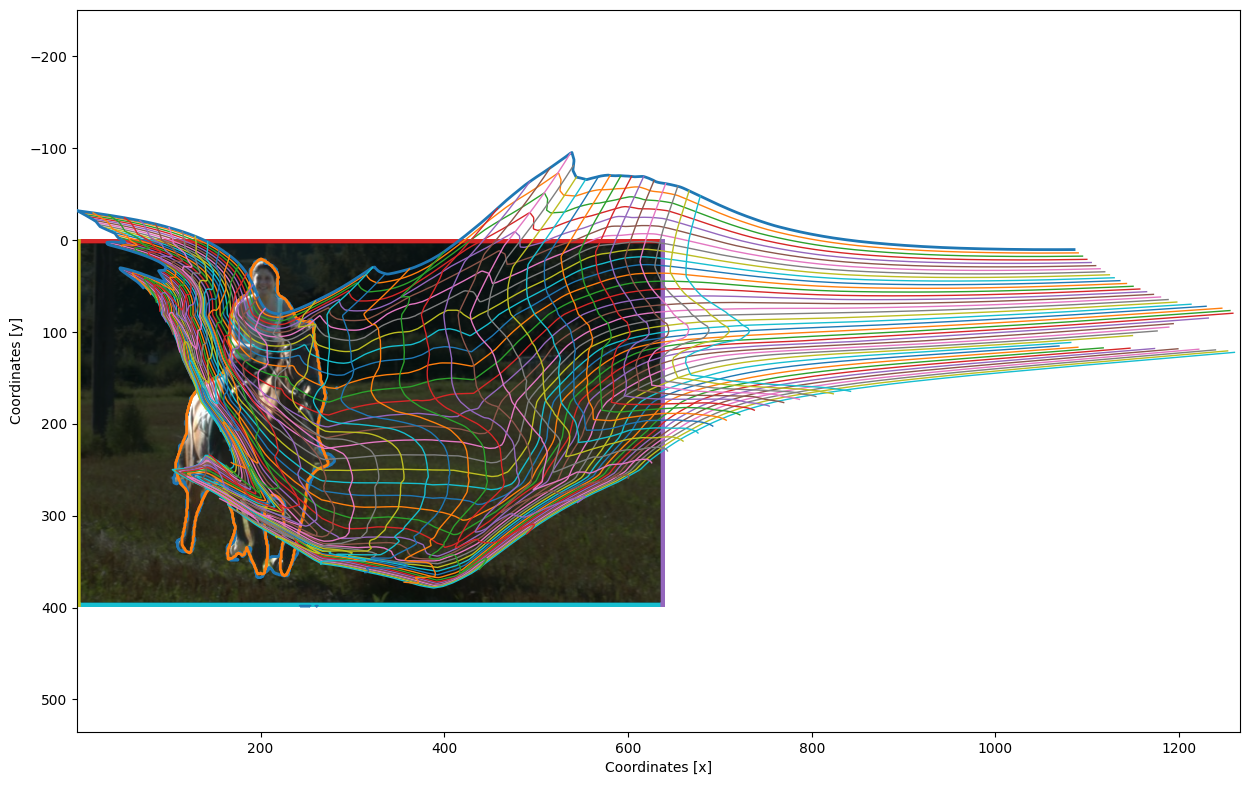

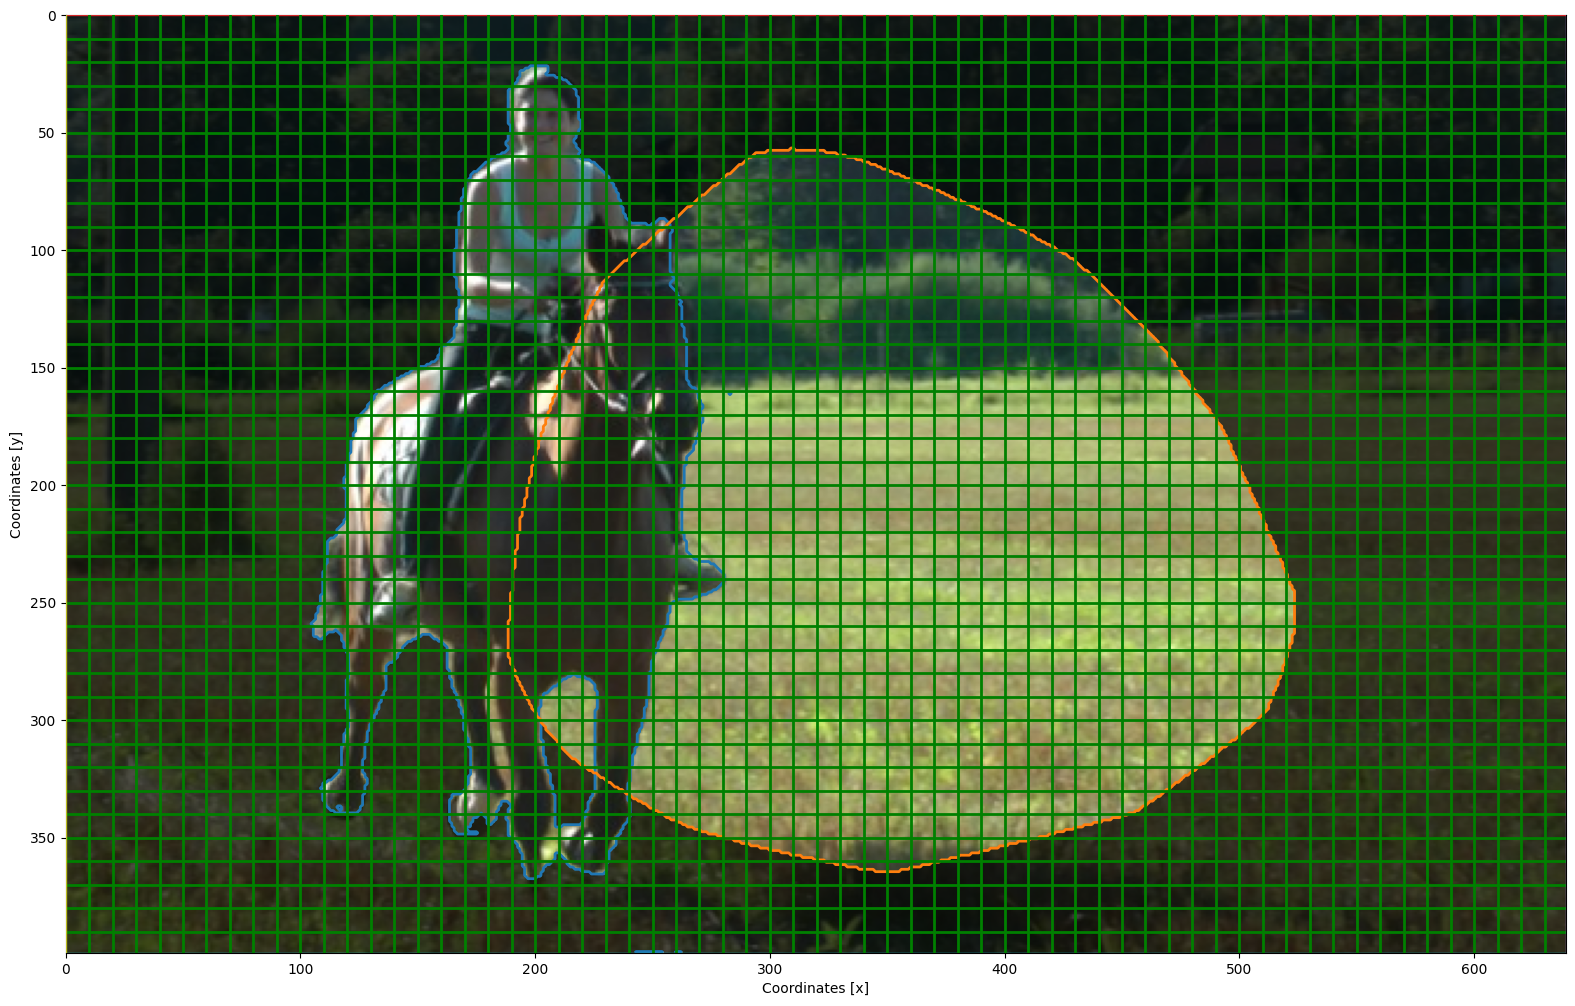

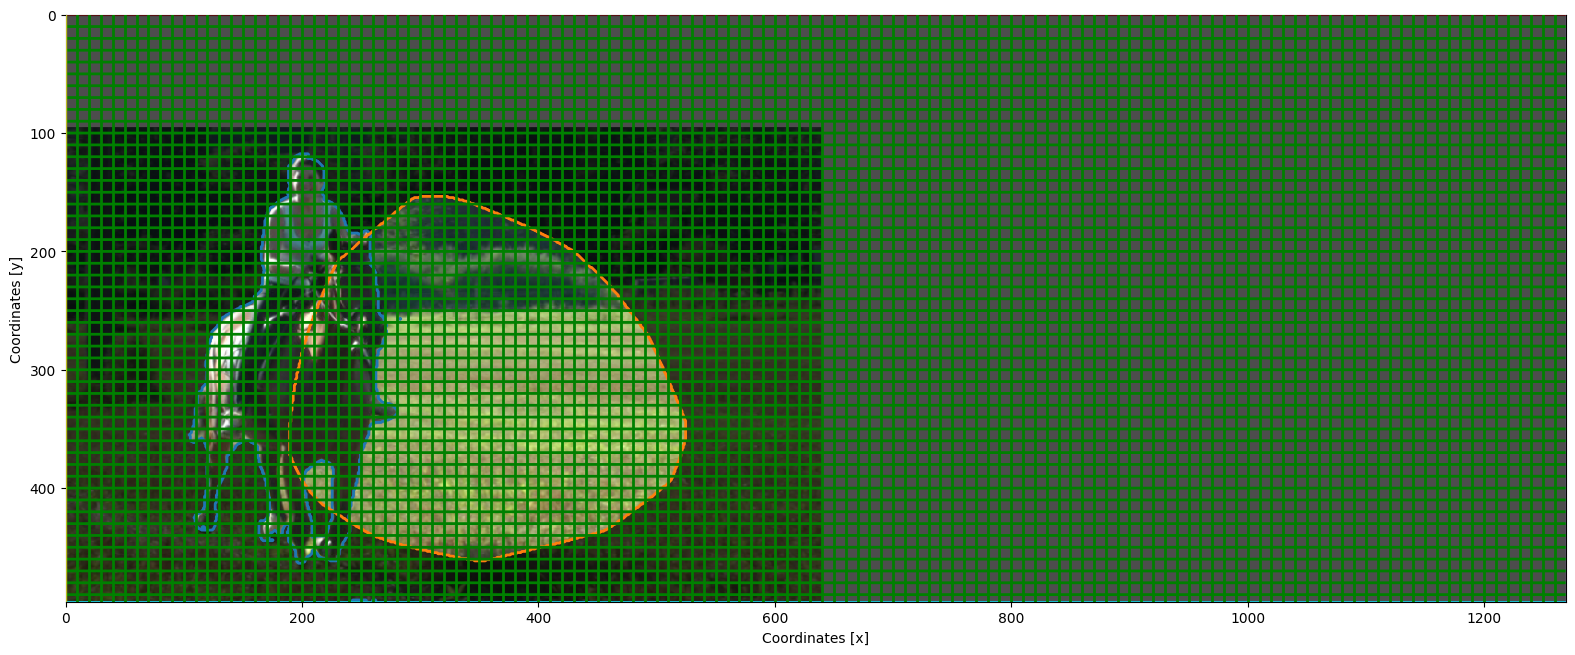

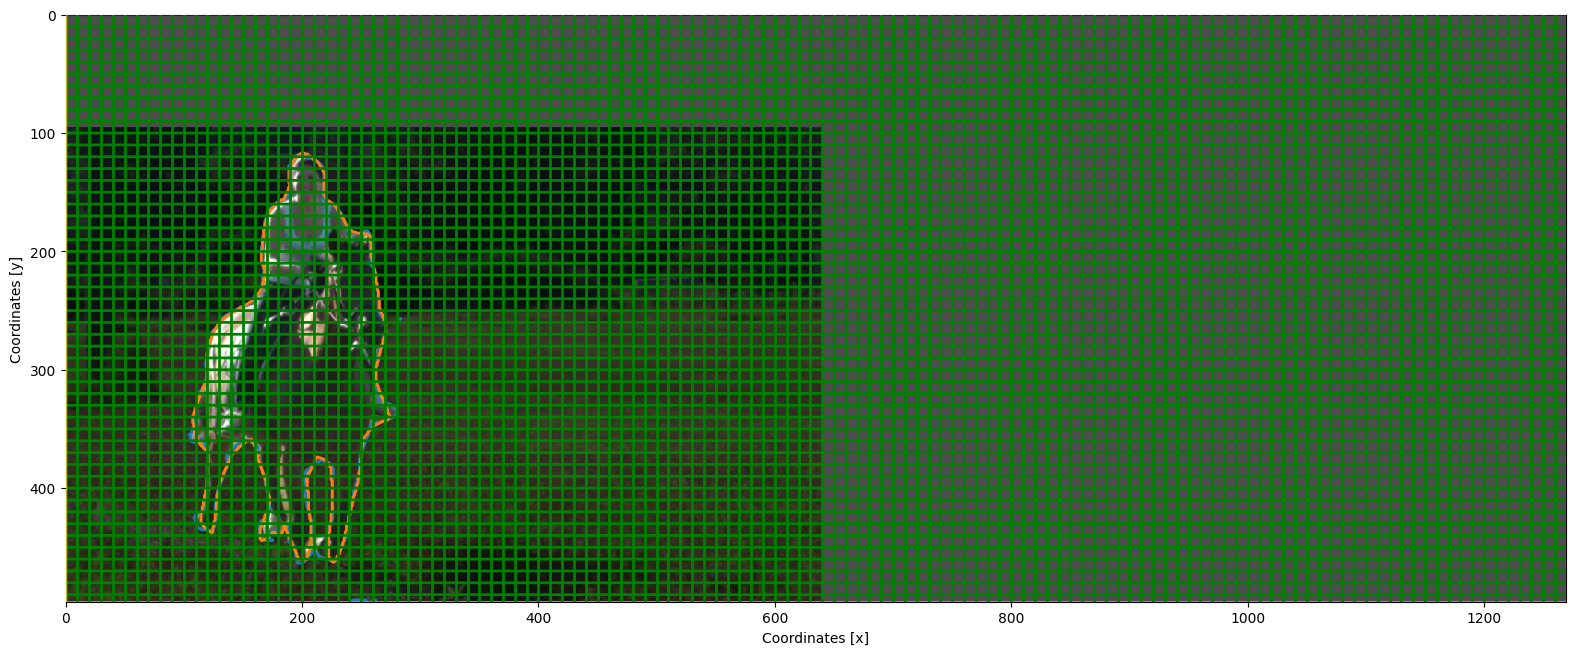

In [3]:
from awesome.model.path_connected_net import PathConnectedNet
import numpy as np
from awesome.run.functions import plot_as_image, subsample_mask, plot_grid, plot_match, plot_output_grid


#indices = range(len(dataloader))
from awesome.util.temporary_property import TemporaryProperty


indices = [index] #len(dataloader)

output_path = "output/deformed_grid_plots/"
os.makedirs(output_path, exist_ok=True)

for i in indices:
    res, ground_truth, img, fg, bg = get_result(model, dataloader, i, model_gets_targets=model_gets_targets)
    res = split_model_result(res, model, dataloader, img)
    res_prior = res.get("prior", None)
    res_pred = res["segmentation"]
    boxes = res.get("boxes", None)
    labels = res.get("labels", None)

    
    with torch.no_grad(), TemporaryProperty(dataloader, do_image_blurring=False, image_channel_format="rgb"):
        model.eval()
        model.to(torch.device("cpu"))
        image_no_blur, ground_truth, _input, targets, fg, bg, prior_state = prepare_input_eval(dataloader, model, i)
        _input_grid = _input[2][None, ...]
        grid = model.prior_module.get_deformation(_input_grid)[0]
        no_deformation = model.prior_module.convex_net(_input_grid)[0]

        step_sizes = (1 / torch.tensor(grid.shape[:-3:-1], dtype=torch.float64))

        # Min y x by diffeo
        min_start = torch.stack([torch.tensor(grid.numpy().min(axis=(-2, -1))), torch.tensor([0, 0])]).min(dim=0).values
        max_end = torch.stack([torch.tensor(grid.numpy().max(axis=(-2, -1))), torch.tensor([1, 1])]).max(dim=0).values
        # Round steps so we have 0,0 inside the grid and same sample points as with the original grid
        
        min_start = -torch.ceil(torch.abs(min_start) / step_sizes) * step_sizes
        max_end = torch.ceil(max_end / step_sizes) * step_sizes

        origin_idx = torch.round(-min_start / step_sizes).int()
        max_original_extend_idx = (origin_idx + torch.tensor(grid.shape[:-3:-1]))

        x = torch.arange(min_start[0], max_end[0] + step_sizes[0], step_sizes[0])
        y = torch.arange(min_start[1], max_end[1] + step_sizes[1], step_sizes[1])
        yy, xx = torch.meshgrid(y, x)

        max_flat_grid = torch.stack([xx, yy], dim=0)[None, ...]
        no_deformation_large_grid = model.prior_module.convex_net(max_flat_grid)[0]
        with_deformation_large_grid = model.prior_module(max_flat_grid)[0]

    fig = plot_output_grid(image_no_blur, 1 - res_prior, 1 - res_pred, grid=grid, 
                      size=15, 
                      subsample=10,
                      grid_linewidth=1,
                      grid_outer_linewidth=2,
                      grid_scale_mode="original",
                      tight=False,
                      save=False,
                      ext=["png", "pdf"],
                      transparent=True,
                      override=True,
                      grid_rows_slicing=slice(0, 40),
                      grid_cols_slicing=slice(0, 40),
                      use_row_coloring=True,
                      use_col_coloring=True,
                      grid_legend=False,
                      path=os.path.join(output_path, f"grid_img_{i}_{dataloader.__dataset__.dataset_name}")
                    )
    
    display(fig)
    plt.close(fig)

    fig = plot_output_grid(image_no_blur, (1 - torch.sigmoid(no_deformation)) > 0.5, 1 - res_pred, grid=_input_grid[0], 
                      size=15, 
                      subsample=10,
                      grid_linewidth=2,
                      grid_outer_linewidth=1,
                      grid_scale_mode="like_image",
                      show_nav_frame=False,
                      tight=True,
                    )
    display(fig)
    plt.close(fig)


    #fig = plot_mask(None, (1 - torch.sigmoid(no_deformation)) > 0)
    #fig = plot_grid(grid, subsample_mask(grid, subsample=10), ax=fig.axes[0])

    enlarged_image = torch.zeros((4, *no_deformation_large_grid.shape[-2:]))
    enlarged_pred = torch.zeros((1, *no_deformation_large_grid.shape[-2:]))
    
    enlarged_image[:, origin_idx[1]:max_original_extend_idx[1], origin_idx[0]:max_original_extend_idx[0]] = torch.cat([image_no_blur, torch.ones_like(image_no_blur[0])[None,]], dim=0)
    enlarged_pred[:, origin_idx[1]:max_original_extend_idx[1], origin_idx[0]:max_original_extend_idx[0]] = 1 - res_pred

    fig = plot_output_grid(enlarged_image, (1 - torch.sigmoid(no_deformation_large_grid)) > 0.5, enlarged_pred, grid=max_flat_grid[0], 
                      size=15, 
                      subsample=10,
                      grid_linewidth=2,
                      grid_outer_linewidth=1,
                      grid_scale_mode="like_image",
                      show_nav_frame=False,
                      tight=True,
                      save=False,
                      ext=["png", "pdf"],
                      transparent=True,
                      path=os.path.join(output_path, f"grid_no_deform_img_{i}_{dataloader.__dataset__.dataset_name}")
                    )
    display(fig)
    plt.close(fig)

    fig = plot_output_grid(enlarged_image, (1 - torch.sigmoid(with_deformation_large_grid)) > 0.5, enlarged_pred, grid=max_flat_grid[0], 
                      size=15, 
                      subsample=10,
                      grid_linewidth=2,
                      grid_outer_linewidth=1,
                      grid_scale_mode="like_image",
                      show_nav_frame=False,
                      tight=True,
                    )

    display(fig)
    plt.close(fig)


    # fig = plot_grid(grid, subsample_mask(grid, subsample=10))
    # display(fig)
    # plt.close(fig)



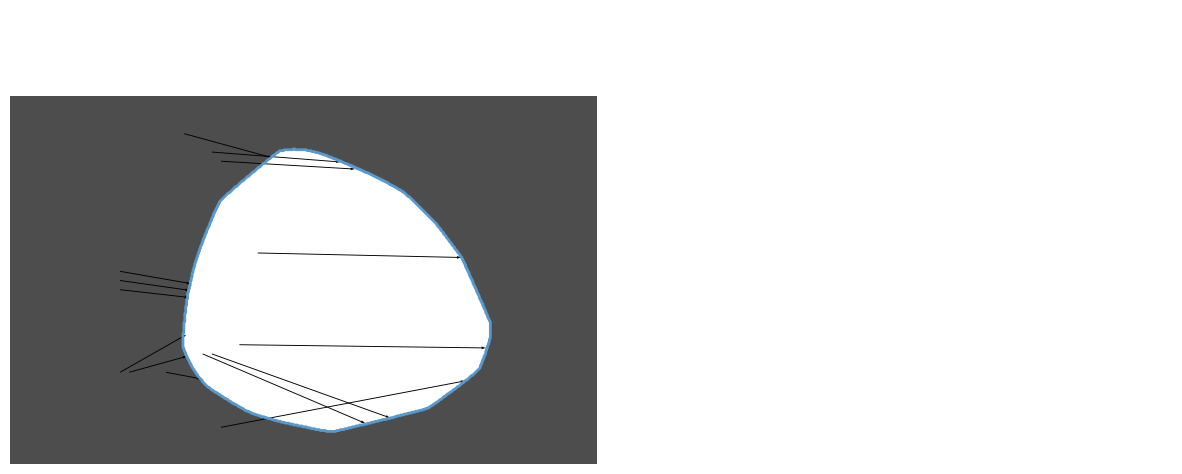

In [5]:
import math
import cv2 as cv

from awesome.run.functions import get_cleaned_up_sam_masks


prior_no_deform_mask = (1 - (torch.sigmoid(no_deformation)) > 0.5)[0]
result_prior = (1 - res_prior).bool()[0]

masks_sam = get_cleaned_up_sam_masks(image_no_blur, result_prior)

contours, _ = cv.findContours((result_prior.numpy() * 255).astype(np.uint8), cv.RETR_TREE, cv.CHAIN_APPROX_NONE)
test_img = torch.zeros_like(prior_no_deform_mask)

contour = contours[0][:, 0, :]
test_img[contour[:, 1], contour[:, 0]] = 1



plt.close("all")
fig, ax = get_mpl_figure(size=15)

def grid_to_original_dim(grid, image_shape):
    return minmax(grid, torch.tensor(0), torch.tensor(1), 0, (torch.tensor(image_shape[::-1]) - 1)[:, None, None])

def grid_to_img_dim(grid, image_shape):
    return minmax(grid, torch.tensor(grid.numpy().min(axis=(-1, -2)))[:, None, None],
                            torch.tensor(grid.numpy().max(axis=(-1, -2)))[:, None, None], 0, 
                            (torch.tensor(image_shape[::-1]) - 1)[:, None, None])


norm_grid = grid_to_original_dim(_input_grid[0], grid.shape[-2:])
target_grid = grid_to_original_dim(grid, grid.shape[-2:])


directions = target_grid - norm_grid

select_grid = torch.zeros_like(directions[0], dtype=torch.bool)
#select_grid[:100, :100] = True

#select_grid[result_prior] = True
select_grid[test_img] = True

plot_mask(None, prior_no_deform_mask, ax=ax)


msk = subsample_mask(directions, subsample=10) & select_grid

starts = norm_grid.permute(1, 2, 0)[msk]
dirs = directions.permute(1, 2, 0)[msk]

ax.quiver(starts[:, 0], starts[:, 1], dirs[:, 0], dirs[:, 1], scale=1, angles="xy", scale_units="xy", units="xy", width=1)
#ax.axis("equal")


x_min = int(math.floor(min(target_grid[0].min().item(), norm_grid[0].min().item())))
x_max = int(math.ceil(max(target_grid[0].max().item(), norm_grid[0].max().item())))

y_min = int(math.floor(max(target_grid[1].max().item(), grid.shape[-2])))
y_max = int(math.ceil(min(target_grid[1].min().item(), norm_grid[1].min().item())))

ax.set_ylim(y_min, y_max)
ax.set_xlim(x_min, x_max)



#ax.axis("equal")
fig


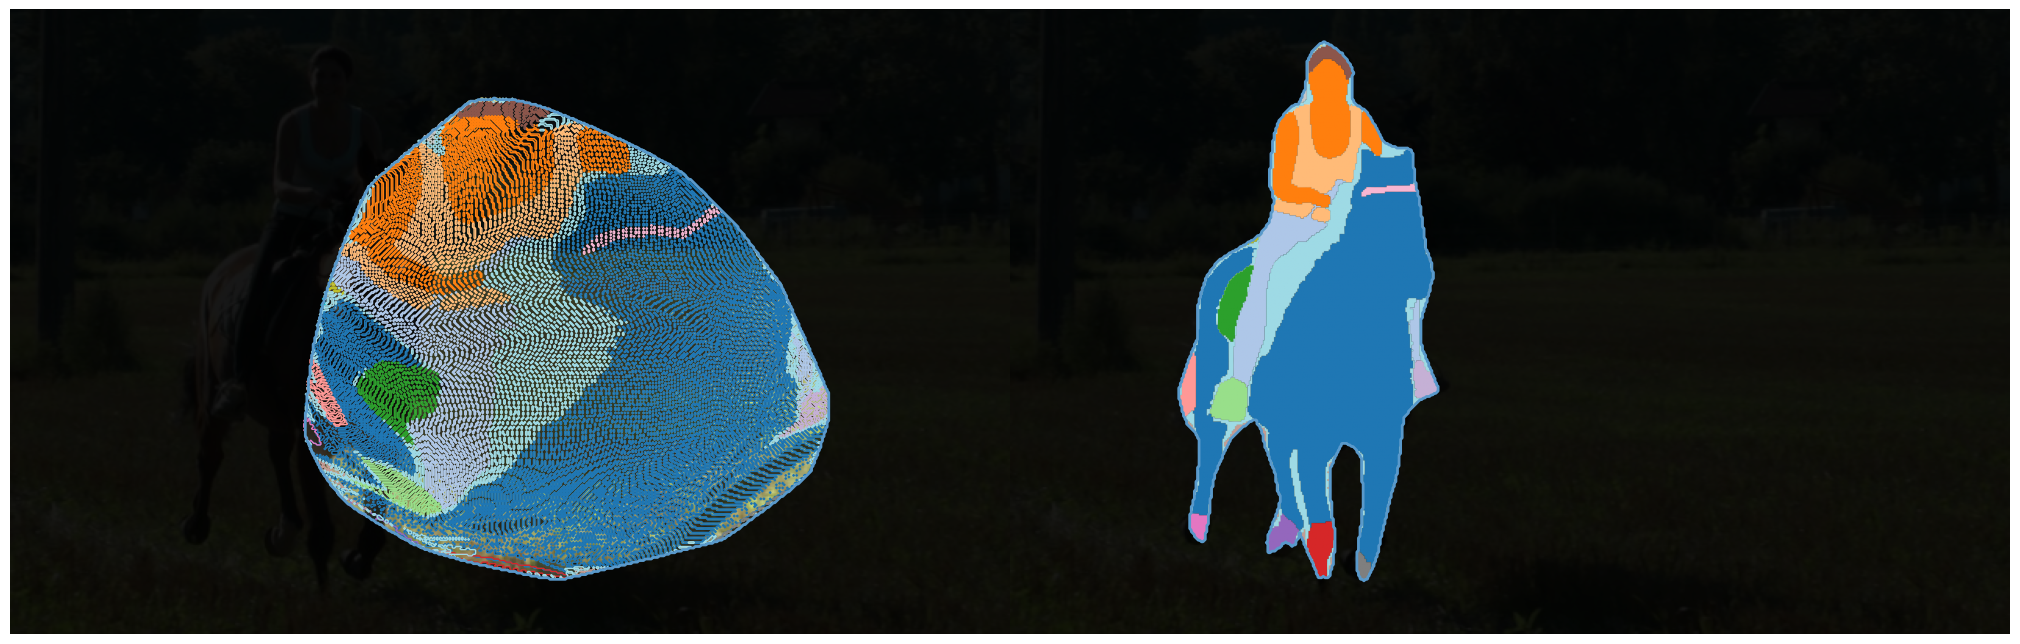

In [12]:
import math
import cv2 as cv

from awesome.run.functions import get_cleaned_up_sam_masks

masks_sam = get_cleaned_up_sam_masks(image_no_blur, result_prior)

prior_no_deform_mask = (1 - (torch.sigmoid(no_deformation)) > 0.5)[0]
result_prior = (1 - res_prior).bool()[0]


def simplistic_flow_net_inverse(norm_grid: torch.Tensor, target_grid: torch.Tensor, shape: torch.Tensor):
    transf = target_grid[:, shape]
    min_xy = norm_grid.min(dim=-1).values.min(dim=-1).values
    max_xy = norm_grid.max(dim=-1).values.max(dim=-1).values
    transf = torch.clamp(transf.T, min_xy, max_xy).T
    transf = transf.int()
    msk = torch.zeros_like(norm_grid[0], dtype=torch.bool)
    msk[transf[1], transf[0]] = True
    return msk

ded_tensor = masks_sam

masks_in_original_convex = torch.zeros_like(ded_tensor, dtype=torch.bool)
masks_in_prior = torch.zeros_like(ded_tensor, dtype=torch.bool)

for i in range(ded_tensor.shape[0]):
    in_msk = ded_tensor[i].bool() & result_prior
    masks_in_prior[i] = in_msk
    masks_in_original_convex[i] = simplistic_flow_net_inverse(norm_grid, target_grid, in_msk)

fig, axes = get_mpl_figure(1, 2, size=10, ratio_or_img=image_no_blur, tight=True)

plot_mask(image_no_blur, masks_in_original_convex, ax=axes[0], filled_contours=False, contour_linewidths=1, size=10)
plot_mask(None, prior_no_deform_mask, ax=axes[0])

fig = plot_mask(image_no_blur, masks_in_prior,ax=axes[1], filled_contours=True, lined_contours=False, size=10)
plot_mask(None, result_prior,ax=axes[1])


In [ ]:
plot_as_image(masks_in_prior[0], size=20)

In [ ]:
test_img = torch.zeros_like(prior_no_deform_mask)

contour = contours[0][:, 0, :]
test_img[contour[:, 1], contour[:, 0]] = 1
plot_as_image(test_img, size=30)

In [ ]:
still_exists

In [ ]:
plot_as_image(missing, size=30)

In [ ]:


import math
cols = 4
rows = math.ceil(dedublicate.shape[0] / cols)

fig, axes = get_mpl_figure(rows, cols, size=15, ratio_or_img=dedublicate)
for i, ax in enumerate(axes):
    if i < dedublicate.shape[0]:
        plot_mask(None, dedublicate[i], ax=ax)
        ax.set_title(f"Mask {i}")

fig

In [ ]:
target_grid[:, 0, 0]

In [ ]:
from matplotlib.colors import to_rgba, get_named_colors_mapping
g = _input_grid[0]
#g = grid

frame_colors = ["tab:red", "tab:purple", "tab:cyan", "tab:olive"]
cmap = get_named_colors_mapping()
for idx, color in enumerate(frame_colors):
    if isinstance(color, str):
        frame_colors[idx] = to_rgba(cmap[color])

msk = subsample_mask(g, subsample=10, also_last=True)
fig = plot_grid(g, msk, size=10, origin=None, outer_line_colors=frame_colors, grid_outer_linewidth=2)

ax = fig.axes[0]
ax.axis("equal")
ax.imshow(img.permute(1,2,0).numpy(), extent=[0, 1, 0, 1])
ax.set_xlabel("x")
ax.set_ylabel("y")
fig

In [ ]:
x.shape

In [ ]:
grid.shape

In [ ]:
_input_grid[0]

In [ ]:
max_flat_grid.shape

In [ ]:
step_sizes

In [ ]:
_input_grid

In [ ]:
origin_idx = min_start / step_sizes
origin_idx

In [ ]:
max_original_extend_idx - origin_idx

In [ ]:
torch.argwhere((torch.isclose(max_flat_grid, torch.tensor(0))).any(dim=(0, )))

In [ ]:
max_flat_grid.shape

In [ ]:
plot_as_image(msk, open=True)

In [ ]:
msk.shape

In [ ]:
_input_grid.shape

In [ ]:
_input_grid

In [ ]:
from awesome.analytics.result_model import ResultModel


path = "runs/fbms_local/eval/unet/joint_realnvp/2024-01-11/#05_UNET+cars3+edge+diffeo+original+joint_24_01_11_17_06_14"
result_model = ResultModel.from_path(path)
runner = result_model.get_runner(0)

model = runner.agent._get_model()
dataloader = runner.agent.training_dataset
model_gets_targets = runner.agent.model_gets_targets

res, ground_truth, img, fg, bg = get_result(model, dataloader, 0, model_gets_targets=model_gets_targets)
res = split_model_result(res, model, dataloader, img)
res_prior = res.get("prior", None)
res_pred = res["segmentation"]
boxes = res.get("boxes", None)
labels = res.get("labels", None)

In [ ]:
from awesome.run.functions import get_mpl_figure, plot_mask, prepare_input_eval
from awesome.util.matplotlib import saveable
import normflows as nf
from typing import Optional, Tuple
from awesome.model.path_connected_net import PathConnectedNet, minmax
from matplotlib.axes import Axes

def coordinate_grid(image_shape):
    x = torch.arange(image_shape[1]).float()
    y = torch.arange(image_shape[0]).float()
    yy, xx = torch.meshgrid(y, x)
    return torch.stack([yy, xx])

def create_circle(image_shape: Tuple[int, int], radius: float, center: Tuple[float, float]):
    grid = coordinate_grid(image_shape)
    yy, xx = grid
    circle = (yy - center[0])**2 + (xx - center[1])**2 <= radius**2
    return circle.float()[None, ...]

def subsample_mask(x,
                   subsample: int = 25):
    image_shape = x.shape[-2:]

    ones_grid = torch.ones(x[0].shape)
    subsampled_grid = torch.zeros(x[0].shape)
    coords = (torch.argwhere(ones_grid) % subsample) == 0
    coords_mask = coords.all(dim=-1).reshape((image_shape))
    subsampled_grid[coords_mask] = 1
    return subsampled_grid.bool()

@saveable()
def plot_output(img, 
                output, 
                target, 
                grid: torch.Tensor, 
                subsample:int = 25, 
                **kwargs):
    image_shape = grid.shape[-2:]
    def denorm_grid(grid):
        image_shape = grid.shape[-2:]
        grid_y = minmax(grid[0], grid[0].min(), grid[0].max(), 0, image_shape[0])
        grid_x = minmax(grid[1], grid[1].min(), grid[1].max(), 0, image_shape[1])
        grid_dnorm = torch.cat([grid_y[None, ...], grid_x[None, ...]], dim=0).detach().cpu().numpy()
        return grid_dnorm

    fig = plot_match(img, output, target, size=5, tight=True, subsample=subsample)
    ax = fig.axes[0]
    dnorm_grid_pt = denorm_grid(grid)

    dnorm_grid_pt = torch.clamp(torch.tensor(dnorm_grid_pt), min=torch.tensor([[[0]], [[0]]]), max=torch.tensor([[[image_shape[0] - 1]], [[image_shape[1] - 1]]])).numpy()
    
    msk = subsample_mask(dnorm_grid_pt, subsample=subsample)

    return plot_grid(dnorm_grid_pt, msk, ax, 'g', origin="lower")
    
@saveable()
def plot_grid(grid: torch.Tensor, 
              mask: torch.Tensor, 
              ax: Optional[Axes] = None, 
              tight: Optional[bool] = False,
              size: Optional[float] = 5,
              color: str = "b",
              dense: bool = True,
              origin: Literal['lower', 'upper'] = "upper"
              ):
    if ax is None:
        fig, ax = get_mpl_figure(1, 1, tight=tight, size=size, ratio_or_img=grid)
    else:
        fig = ax.figure

    dots = torch.argwhere(mask)

    col_idx = torch.unique(dots[:, 0])
    row_idx = torch.unique(dots[:, 1])

    cols = grid[:, col_idx]
    rows = grid[:, :, row_idx]

    for idx in range(cols.shape[1]):
        col = cols[:, idx]
        if dense:
            x = col[1]
            y = col[0]
        else:
            x = col[1, row_idx]
            y = col[0, row_idx]
        ax.plot(x, y, color=color)

    for idx in range(rows.shape[2]):
        row = rows[:, :, idx]
        if dense:
            x = row[1]
            y = row[0]
        else:
            x = row[1, col_idx]
            y = row[0, col_idx]
        ax.plot(x, y, color=color)

    if origin == "upper":
        ax.invert_yaxis()
    return fig


def plot_match(img, 
               output, 
               target, 
               subsample:int = 25, 
               grid: torch.Tensor = None,
               **kwargs):

    image_shape = img.shape[-2:]
    if grid is None:
        grid = coordinate_grid(image_shape)

    subsampled_grid = torch.zeros_like(grid[0])

    coords_mask = subsample_mask(grid, subsample=subsample)
    subsampled_grid[coords_mask] = 1

    add = []

    if target is not None:
        add.append(target)
    if output is not None:
        add.append(output)
    
    add.append(subsampled_grid.float()[None, ...])

    stack_plot = torch.cat(add, dim=0)

    fig = plot_mask(img, stack_plot, **kwargs)
    return fig


